In [3]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

plt.rcParams['figure.figsize'] = [16, 10]
warnings.filterwarnings('ignore')

# Data understanding


In [68]:
np.random.seed(2333)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./submission.csv')

In [69]:
print('There are {} training rows and {} test rows.'.format(train.shape[0], test.shape[0]))
print('There are {} training columns and {} test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

There are 146001 training rows and 30000 test rows.
There are 7 training columns and 6 test columns.


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0


In [71]:
# check if there are missing values
print("training set:", train.isnull().sum())
print("test set:", test.isnull().sum())

train_nonull = train.dropna(how='any', inplace=False)
print("updated:", train_nonull.isnull().sum())

training set: row_id         0
start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64
test set: row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64
updated: row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
duration     0
dtype: int64


In [72]:
print("Average trip duration:", train_nonull['duration'].mean())
print("Max. trip duration:", train_nonull['duration'].max())

# TODO: elimintate unreasonable duration
# ~1000 column with duration >= 40000
train_nonull.nlargest(10, 'duration') # boundary: 1025

Average trip duration: 1065.8049323797768
Max. trip duration: 42168.0


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
15152,15152,-74.008102,40.738548,-73.973732,40.789421,2015-02-01 16:17:12,42168.0
32,32,-73.941292,40.787903,-73.932327,40.794922,2015-04-19 14:53:48,40000.0
162,162,-73.951447,40.774029,-73.977524,40.764542,2015-03-15 00:49:28,40000.0
191,191,-74.007095,40.743675,-73.994583,40.750618,2015-04-04 21:26:13,40000.0
332,332,-73.978447,40.777508,-73.983139,40.781422,2015-06-02 21:18:39,40000.0
349,349,-74.004578,40.724033,-74.009193,40.720688,2015-10-09 10:35:58,40000.0
452,452,-73.983459,40.729961,-73.962967,40.716503,2015-08-10 22:46:05,40000.0
542,542,-73.990013,40.756950,-73.978386,40.752251,2015-04-02 22:51:25,40000.0
592,592,-73.949409,40.777802,-73.991531,40.754902,2015-01-11 21:50:21,40000.0
795,795,-73.985260,40.747040,-73.992729,40.736679,2015-09-05 14:42:05,40000.0


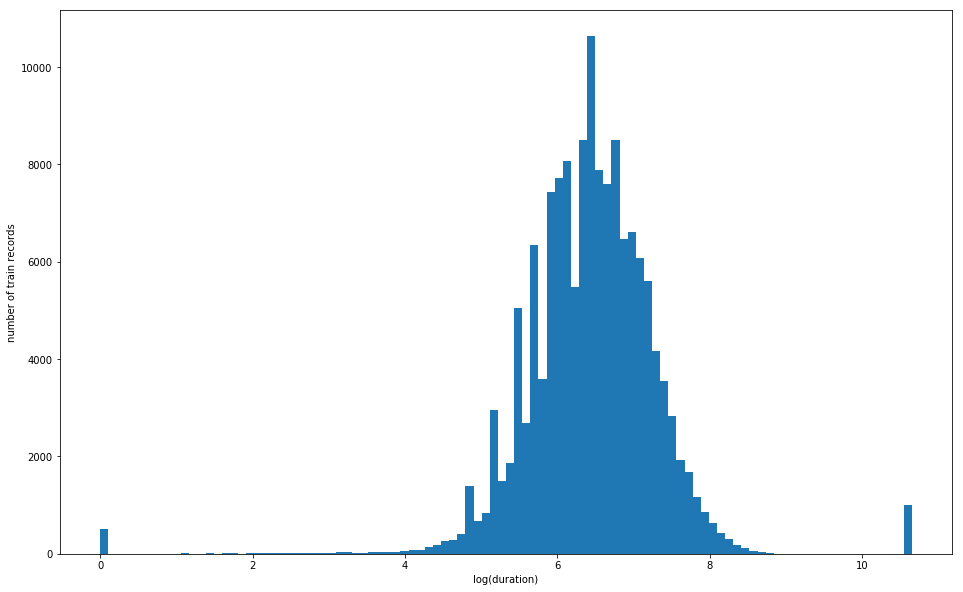

In [74]:
train_nonull['log_duration'] = np.log(train_nonull['duration'].values + 1)
plt.hist(train_nonull['log_duration'].values, bins=100)
plt.xlabel('log(duration)')
plt.ylabel('number of train records')
plt.show()

In [88]:
train_dur = train_nonull.loc[(train_nonull['log_duration'] >= 0.5) & (train_nonull['log_duration'] <= 10)]
print(train_dur.shape[0])

143489


In [ ]:
plt.plot(train_dur.groupby('datetime').count()[['row_id']], 'o-', label='train')
plt.plot(test.groupby('datetime').count()[['row_id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()